In [37]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
import seaborn as sns
import copy

In [38]:
data = pd.read_csv("/Users/veera/Data/Repos/Udemy/.dataset/mnist_train.csv", delimiter=',', header=None)
labels = data[0]
data = data.drop(columns=[0])
data = np.array(data)
labels = np.array(labels)
# The min and max values of the data are 0 and 255
# It is normalized to 0 and 1
data_norm = data/np.max(data)

In [39]:
data_tensor = torch.tensor(data_norm).float()
label_tensor = torch.tensor(labels).long()
x_train, x_test, y_train, y_test = train_test_split(data_tensor, label_tensor,train_size=0.8, stratify=label_tensor)
train_data = TensorDataset(x_train, y_train)
test_data = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_data, batch_size=64, drop_last=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [40]:
def create_model():
    class ann(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.input = nn.Linear(784, 64)
            self.hidden1 = nn.Linear(64, 32)
            self.hidden2 = nn.Linear(32, 32)
            self.output = nn.Linear(32, 10)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.hidden1(x))
            x = F.relu(self.hidden2(x))
            x = F.relu(self.output(x))
            return x
    net = ann()
    lossfn = nn.CrossEntropyLoss()
    # NegativeLogLikelihood
    opt = torch.optim.SGD(net.parameters(), lr=0.01)

    return net, lossfn, opt

In [41]:
def train(nn, loss_fn, opt):
    epochs = 100

    # store losses
    losses = []
    train_acc = []
    test_acc = []

    # initialize weight matrices
    weight_change = np.zeros((epochs, 4))
    weight_conds = np.zeros((epochs, 4))

    for i in range(epochs):
        pre_w = []
        for p in nn.named_parameters():
            if 'weight' in p[0]:
                pre_w.append(copy.deepcopy(p[1].data.numpy()))

        # training
        nn.train()
        batchacc = []
        batchloss = []
    
        for trainx, trainy in train_loader:
            # batch train
            yhat = nn(trainx)
            loss = loss_fn(yhat, trainy)

            opt.zero_grad()
            loss.backward()
            opt.step()

            batchloss.append(loss.item())
            matches = torch.argmax(yhat, axis=1) == trainy # Booleans
            matches_num = matches.float() # convert booleans to numbers
            accuracy = 100 * torch.mean(matches_num)
            batchacc.append(accuracy)
        train_acc.append(np.mean(batchacc))
        losses.append(np.mean(batchloss))

        # testing
        nn.eval()
        testx, testy = next(iter(test_loader))
        with torch.no_grad():
            yhat = nn(testx)
        test_acc.append(100*torch.mean((torch.argmax(yhat, axis=1)==testy).float()))

        for j, p in enumerate(nn.named_parameters()):
            if 'weight' in p[0]:
                weight_conds[i, int(j/2)] = np.linalg.cond(p[1].data)
                weight_change[i, int(j/2)] = np.linalg.norm(pre_w[int(j/2)]-p[1].data.numpy(), ord='fro')
    return train_acc, test_acc, losses, weight_change, weight_conds, pre_w

In [42]:
net, lossfn, opt = create_model()

In [43]:
train_acc, test_acc, losses, weight_change, weight_conds, pre_w = train(net, lossfn, opt)

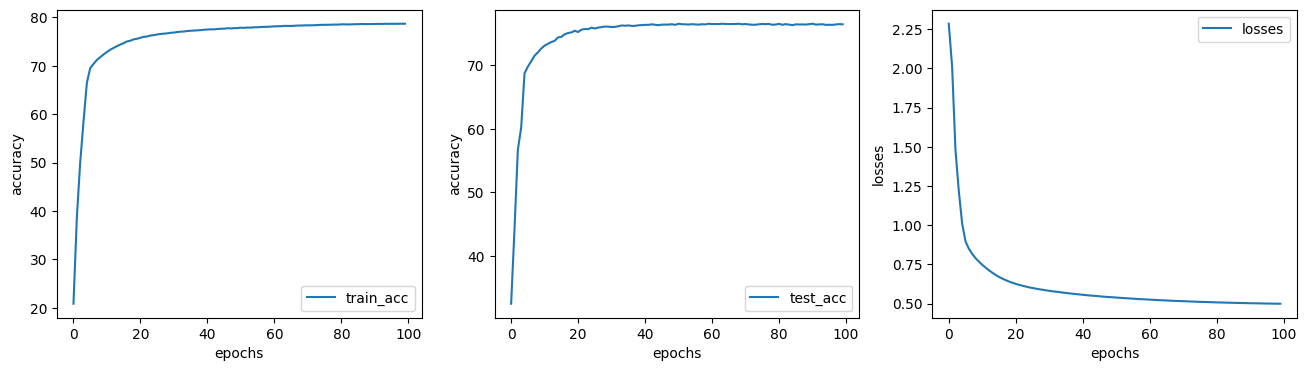

In [44]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].plot(range(100), train_acc)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy')
ax[0].legend(['train_acc'])

ax[1].plot(range(100), test_acc)
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend(['test_acc'])


ax[2].plot(range(100), losses)
ax[2].set_xlabel('epochs')
ax[2].set_ylabel('losses')
ax[2].legend(['losses'])

In [52]:
layername = []
for i in net.named_parameters():
    if 'weight' in i[0]:
        layername.append(i[0][:-7])

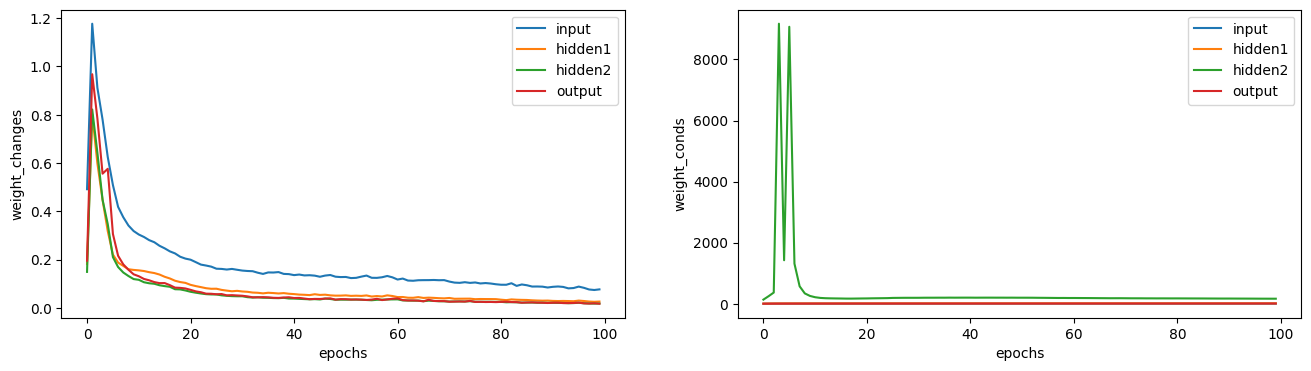

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))
ax[0].plot(range(100), weight_change)
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('weight_changes')
ax[0].legend(layername)

ax[1].plot(range(100), weight_conds)
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('weight_conds')
ax[1].legend(layername)


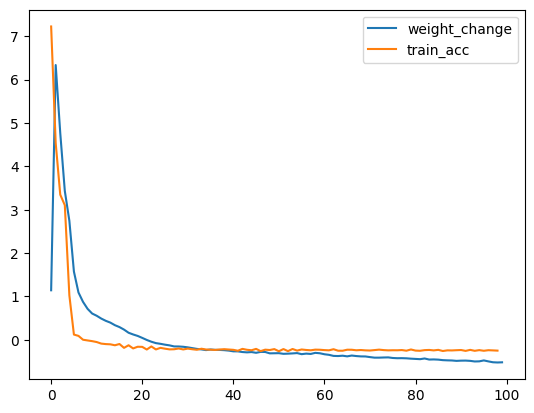

In [64]:
from scipy.stats import zscore
plt.plot(zscore(np.mean(weight_change, axis=1)), label="weight_change")
plt.plot(zscore(np.diff(train_acc)), label="train_acc")
plt.legend()